In [1]:
import os
import ast
import json
import string
import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from langchain import PromptTemplate

from src.DST.evaluate_utils import remapping
from src.DST.dst import SLOTS_DESCRIPTIONS, SLOTS_REVERSE_REMAPPING
from src.config import CONFIG

from dataclasses import dataclass, field
from typing import Optional
from transformers import TrainingArguments
from src.DST.evaluate_utils import unpack_belief_states, fix_typos, nested_fix, remapping


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)



@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to utilize.
    """
    model_name_or_path: Optional[str] = field(
        default="openai/gpt-3.5-turbo",
        metadata={"help": "The path of the HuggingFace model."}
    )
    use_int8: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to use int8 model or not."}
    )
    use_deepspeed: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to use deepspeed model or not."}
    )
    

@dataclass
class DataArguments:
    """
    Arguments pertaining to the data loading and preprocessing pipeline.
    """
    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "Train dataset path"}
    )
    dataset_names: Optional[str] = field(
        default=None,
        metadata={"help": "Train dataset paths"}
    )
    root_data_path: Optional[str] = field(
        default="./data", metadata={"help": "The path to the data directory."},
    )
    mwoz_path: Optional[str] = field(
        default="/home/willy/instructod/MultiWOZ_2.1/",
        metadata={"help": "MWOZ path"}
    )
    dialog_history_limit_dst: Optional[int] = field(
        default=0,
        metadata={"help": "Lenght of dialogue history for dst"}
    )
    dialog_history_limit_dst_recorrect: Optional[int] = field(
        default=0,
        metadata={"help": "Lenght of dialogue history for dst update"}
    )
    dialog_history_limit_rg: Optional[int] = field(
        default=20,
        metadata={"help": "Lenght of dialogue history for response generation"}
    )
    dialog_history_limit_e2e: Optional[int] = field(
        default=20,
        metadata={"help": "Lenght of dialogue history for e2e"}
    )
    single_domain_only: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to keep only the single domain sample or not"}
    )
    with_slot_description: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to use slot description or not for DST"}
    )
    with_req_inf_differentiation: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to differentiate between require and inform slot for DST"}
    )
    with_all_slots: Optional[bool] = field(
        default=True,
        metadata={"help": "Whether to use all slots or not"}
    )
    debug_mode: Optional[bool] = field(
        default=False,
        metadata={"help": "debug mode to only try 20 samples"}
    )
    start_idx: Optional[int] = field(
        default=0,
        metadata={"help": "Starting index to restart the prediction if needed"}
    )
    save_path: Optional[str] = field(
        default="results/",
        metadata={"help": "save path"}
    )
    save_every: Optional[int] = field(
        default=5,
        metadata={"help": "every step to save in case api fail"}
    )
    db_format_type: Optional[str] = field(
        default="1",
        metadata={"help": "1 is more precise, 2 is more concise for db integration"},
    )
    with_slot_domain_diff: Optional[bool] = field(
        default=False,
        metadata={"help": "differentiation between slot and domain"}
    )
    

@dataclass
class PromptingArguments(TrainingArguments):
    """
    Arguments pertraining to the prompting pipeline.
    """
    output_dir: Optional[str] = field(
        default="./out",
        metadata={"help": "Output directory"},
    )
    task: Optional[str] = field(
        default="dst",
        metadata={"help": "Task to perform"}
    )
    max_requests_per_minute: Optional[int] = field(
        default=20,
        metadata={"help": "Max number of requests for OpenAI API."}
    )
    openai_api_key_name: Optional[str] = field(
        default="OPENAI_API_KEY",
        metadata={"help": "OpenAI API key name."}
    )

class PromptConstructor():
    def __init__(self, 
                 config):
        self.config = config
        self.instructions = config["INSTRUCTIONS"]
        self.prompt_templates = config["PROMPT_TEMPLATES"]
        self.examples = config["EXAMPLES"]
        
    def _get_slots_from_domains(self, domains, ontology, with_slot_description, with_all_slots, with_slot_domain_diff):
        
        if with_all_slots:
            domains = ["restaurant", "train", "attraction", "hotel", "taxi"]
        
        slots = []
        for slot in list(ontology.keys()):
            splitted_slot = slot.split("-")
            if splitted_slot[0] in domains:
                if with_slot_domain_diff:
                    if splitted_slot[-1] not in slots:
                        slots.append(splitted_slot[-1])
                else:
                    slots.append(splitted_slot[0] + "-" + splitted_slot[-1])
        
        slots_info = []
        added_slots = []
        if with_slot_description:
            for slot in slots:
                splitted_slot = slot.split("-")
                if with_slot_domain_diff:
                    if slot in added_slots:
                        continue
                    slots_info.append(f"name: {slot}, description: {SLOTS_DESCRIPTIONS[slot.lower()]}")
                    added_slots.append(slot)
                else:
                    slots_info.append(f"name: {slot}, description: {SLOTS_DESCRIPTIONS[splitted_slot[1].lower()]}")

                    
            slots = slots_info
        
        slots_prompt = "\n".join(slots)
        if with_slot_domain_diff:
            return slots_prompt + f"\n\nDOMAINS: {', '.join(domains)}"
        else:
            return slots_prompt
            
                
                
#         if with_all_slots:
#             domains = "all"
        
#         if with_slot_description:
#             with_req_inf_differentiation = False #Slot description is the discriminator

#         if domains == "all":
#             if with_req_inf_differentiation:
#                 req_slots = ", ".join(self.config["multiwoz21"]["all_requestable_slots"])
#                 inf_slots = ", ".join(self.config["multiwoz21"]["all_informable_slots"])
#             else:
#                 slots = set(self.config["multiwoz21"]["all_requestable_slots"] + 
#                             self.config["multiwoz21"]["all_informable_slots"])
#                 slots = ", ".join(slots)
#         elif not isinstance(domains, list):
#             raise ValueError("""Provided domain should be either 'all' or list of valid domain names:
#                                 - for multiwoz2.1 and 2.4: taxi, restaurant, hotel, train, attraction""")
#         else:
#             req_slots = ""
#             inf_slots = ""
#             domain_req_slots = []
#             domain_inf_slots = []
#             for domain in domains:
#                 domain_req_slots += self.config["multiwoz21"]["requestable_slots"][domain]
#                 domain_inf_slots += self.config["multiwoz21"]["informable_slots"][domain]
#             if with_req_inf_differentiation:
#                 domain_req_slots = set(domain_req_slots)
#                 domain_inf_slots = set(domain_inf_slots)
#                 req_slots += ", ".join(domain_req_slots)
#                 inf_slots += ", ".join(domain_inf_slots)
#             else:
#                 slots = set(domain_req_slots + domain_inf_slots)
#                 slots = ", ".join(slots)

#         if with_req_inf_differentiation:
#             slots_info = f"Requestable slots: {req_slots}\nInformable slots: {inf_slots}"
#         else:
#             slots_info = f"{slots}"

#         if with_slot_description:
#             slots = slots.split(", ")
#             slots_info = ""
#             for slot in slots:
#                 if slot not in self.config["multiwoz21"]["all_informable_slots"]:
#                     continue
#                 slots_info += f"name: {slot}, description: {SLOTS_DESCRIPTIONS[slot]}\n"
#             slots_info = slots_info[:-2]
        
#         return slots_info
    
    
    def _build_prompt(self, mode="", example="", dialogue_context="", ontology="", slots="", dialogue_acts="", belief_states="", database=""):
        prompt = ""
        if mode == "dst":
            instruction = self.instructions["instruction_with_slots"]
            template_variables = self.prompt_templates["template_with_slots"]
            template = PromptTemplate(input_variables= template_variables["input_variables"],
                                      template = template_variables["template"])
            prompt = template.format(instruction=instruction,
                                     slots=slots,
                                     example=example,
                                     dialogue_context=dialogue_context)
            
        elif mode == "dst_recorrect":
            instruction = self.instructions["instruction_with_slots_recorrect"]
            template_variables = self.prompt_templates["template_with_slots_recorrect"]
            template = PromptTemplate(input_variables= template_variables["input_variables"],
                                      template = template_variables["template"])            
            prompt = template.format(instruction=instruction,
                                    slots=slots,
                                    dialogue_context=dialogue_context,
                                    belief_states=belief_states)
            
        elif mode == "database_query":
            instruction = self.instructions["instruction_query_database"]
            template_variables = self.prompt_templates["template_query_database"]
            template = PromptTemplate(input_variables= template_variables["input_variables"],
                                      template = template_variables["template"])
            prompt = template.format(instruction=instruction,
                                     belief_states=belief_states)
            
        elif mode == "response_generation":
            example = self.config["EXAMPLES"]["response_generation"]
            
            instruction = self.instructions["instruction_response_generation"]
            template_variables = self.prompt_templates["template_response_generation"]
            template = PromptTemplate(input_variables = template_variables["input_variables"],
                                      template = template_variables["template"])
            prompt = template.format(instruction=instruction,
                                     example=example,
                                     dialogue_context=dialogue_context)
        elif mode == "e2e":
            instruction = self.instructions["instruction_e2e"]
            template_variables = self.prompt_templates["template_e2e"]
            template = PromptTemplate(input_variables = template_variables["input_variables"],
                                      template = template_variables["template"])
            prompt = template.format(instruction=instruction,
                                     database=database,
                                     dialogue_context=dialogue_context)

        else:
            raise ValueError("'mode' should be one of: [dst, dst_recorrect, database_query, response_generation, e2e]")
        
        return prompt


class MWOZ_Dataset(PromptConstructor):
    def __init__(self,
                 config,
                 data_args):
        PromptConstructor.__init__(self, config)
        self.dataset = {"id":[],
                        "dialogue_id":[],
                        "dialogue_context":[],
                        "turn":[],
                        "prompt_dst":[],
                        "prompt_dst_update":[],
                        "prompt_rg":[],
                        "prompt_e2e":[],
                        "domains":[],
                        "turn_domain":[],
                        "gold_turn_bs":[],
                        "gold_bs":[],
                        "gold_act":[],
                        "gold_response":[],
                        "gold_database_result":[],
                        }
        
        print("Loading data...")
        self.all_data, self.testfiles, self.system_acts, self.ontology = self._get_mwoz_data(data_args.mwoz_path)
        print("Loading databases...")
        self.dbs_lexicalized = self._get_dbs_lexicalized(data_args.mwoz_path, data_args.db_format_type)
        self.idx = 0
        self.dialog_history_limit_dst = data_args.dialog_history_limit_dst
        self.dialog_history_limit_rg = data_args.dialog_history_limit_rg
        self.dialog_history_limit_e2e = data_args.dialog_history_limit_e2e
        self.single_domain_only = data_args.single_domain_only
        self.with_slot_description = data_args.with_slot_description
        self.with_slot_domain_diff = data_args.with_slot_domain_diff
        self.with_all_slots = data_args.with_all_slots
        self.all_domains = ["restaurant", "taxi", "hotel", "train", "attraction"]

        print("Processing mwoz...")
        for sample in tqdm(self.all_data):
            if sample in self.testfiles:
                dialogue_log = self.all_data[sample]["log"]
                self._process_dialogue_log(sample=sample,
                                           dialogue_log=dialogue_log)

        self.dataset = pd.DataFrame(self.dataset)
        if self.single_domain_only:
            for index, row in tqdm(self.dataset.iterrows()):
                if "sng" not in row["dialogue_id"].lower():
                    self.dataset.drop(index, inplace=True)

        for index, row in self.dataset.iterrows():
            if row["turn_domain"] == "":
                self.dataset.loc[index, 'turn_domain'] = row["domains"][0]

                    
    def _get_mwoz_data(self, mwoz_path):
        data_path = os.path.join(mwoz_path, "data.json")
        testListFile_path = os.path.join(mwoz_path, "testListFile.txt")
        system_acts_path = os.path.join(mwoz_path, "system_acts.json")
        ontology_path = os.path.join(mwoz_path, "ontology.json")

        with open(data_path, "r") as f:
            all_data = json.load(f)
            
        with open(testListFile_path, "r") as f:
            testfiles = f.read()
        testfiles = testfiles.split("\n")
        
        with open(system_acts_path, "r") as f:
            system_acts = json.load(f)
            
        with open(ontology_path, "r") as f:
            ontology = json.load(f)
            
        return all_data, testfiles, system_acts, ontology
    
    def _get_dbs_lexicalized(self, mwoz_path, format_type):
        domains = ["restaurant", "hotel", "train", "attraction"]
        keep_data = {"restaurant":["address", "area", "food", "name", "pricerange", "phone", "postcode"],
                    "attraction":["name", "area", "address", "type", "postcode"],
                    "hotel":["name", "address", "area", "phone", "postcode", "pricerange", "stars"],
                    "train":["departure", "destination"]}
        dbs_lexicalized = {}
        for domain in domains:
            db_path = os.path.join(mwoz_path, f"{domain}_db.json")
            with open(db_path, "r") as f:
                db_data = json.load(f)

            db_lexicalized = []
            if format_type == "1":
                for row in db_data:
                    row_keep = []
                    for key in keep_data[domain]:
                        if key in row:
                            row_keep.append(f"{key}: {row[key]}")
                    db_lexicalized.append(", ".join(row_keep))
            
            elif format_type == "2":
                #more concise db to fit in context length limit
                db_lexicalized.append(", ".join(keep_data[domain]))
                for row in db_data:
                    row_keep = []
                    for key in keep_data[domain]:
                        if key in row:
                            row_keep.append(f"{row[key]}")
                    db_lexicalized.append(", ".join(row_keep))
                    # db_lexicalized.append(", ".join([f"{row[key]}" for key in keep[domain]]))
            dbs_lexicalized[domain] = "\n".join(set(db_lexicalized))

        return dbs_lexicalized
    
    def _process_dialogue_log(self, sample, dialogue_log):

        dialog_history_memory_dst = []
        dialog_history_memory_rg = []
        dialog_history_memory_e2e = []
        dialog_history_dst = ""
        dialog_history_rg = ""
        dialog_history_e2e = ""
        turn_domain = ""
        domains = self._get_domains_from_log(dialogue_log)
        slots = self._get_slots_from_domains(domains=domains, 
                                             ontology=self.ontology,
                                             with_slot_description=self.with_slot_description,
                                             with_slot_domain_diff=self.with_slot_domain_diff,
                                             with_all_slots=self.with_all_slots) # or all
        if self.dialog_history_limit_dst == 0:
            example = self.examples["dst_dh0"]
        else:
            example = self.examples["dst_dh-1"]

        for turn_nb, turn in enumerate(dialogue_log):

            if turn_nb % 2 == 0:
                speaker = "USER"
            else:
                speaker = "SYSTEM"
            
            utterance = f"""{speaker}: {turn["text"]}\n"""
            dialog_act = turn["dialog_act"]
            cur_system_act = self.system_acts[sample.split(".")[0]][str((turn_nb//2)+1)]
            
            dialogue_context_dst = dialog_history_dst + utterance
            prompt_dst = self._build_prompt(mode="dst",
                                            slots=slots,
                                            example=example,
                                            dialogue_context=dialogue_context_dst)
            
            lexicalized_act = self._lexicalize_act(cur_system_act)
            dialogue_context_rg = dialog_history_rg + utterance + f"ACT:{lexicalized_act}\nSYSTEM:"
            prompt_rg = self._build_prompt(mode="response_generation",
                                            dialogue_context=dialogue_context_rg)
            
            dialogue_context_e2e = dialog_history_e2e + utterance + "SYSTEM:"
    
            turn_domain = self._get_domain_from_turn(turn_domain, cur_system_act)
            if turn_domain and turn_domain != "taxi":
                database = self.dbs_lexicalized[turn_domain]
            else:
                database = ""
            prompt_e2e = self._build_prompt(mode="e2e",
                                            database=database,
                                            dialogue_context=dialogue_context_e2e).replace("\n\n\n", "\n")

            dialog_history_dst, dialog_history_memory_dst = self._update_dialogue_memory(utterance, 
                                                                                         dialogue_log, 
                                                                                         self.dialog_history_limit_dst, 
                                                                                         dialog_history_memory_dst)
            dialog_history_rg, dialog_history_memory_rg = self._update_dialogue_memory(utterance, 
                                                                                       dialogue_log, 
                                                                                       self.dialog_history_limit_rg,
                                                                                       dialog_history_memory_rg)
            dialog_history_e2e, dialog_history_memory_e2e = self._update_dialogue_memory(utterance, 
                                                                                         dialogue_log, 
                                                                                         self.dialog_history_limit_e2e, 
                                                                                         dialog_history_memory_e2e) 
                
            metadata = turn["metadata"]
            bspn = {}
            if metadata:
                for domain in domains:
                    for k, v in metadata[domain].items():
                        for slot, value in v.items():
                            if isinstance(value, str) and value not in ["", "not mentioned", "none"]:
                                bspn[domain+"-"+slot] = value
            self.idx += 1
            if turn_nb % 2 == 0:
                self.dataset["gold_turn_bs"].append(dialog_act)
                self.dataset["dialogue_context"].append(dialogue_context_dst)
                self.dataset["gold_database_result"].append(None) 
                self.dataset["turn"].append(turn_nb//2)
                self.dataset["domains"].append(domains)
                self.dataset["id"].append(self.idx//2)
                self.dataset["dialogue_id"].append(sample)
                self.dataset["prompt_dst"].append(prompt_dst)
                self.dataset["prompt_dst_update"].append(prompt_dst)
                self.dataset["prompt_rg"].append(prompt_rg)
                self.dataset["prompt_e2e"].append(prompt_e2e)
                self.dataset["turn_domain"].append(turn_domain)
            else:
                self.dataset["gold_response"].append(utterance)
                self.dataset["gold_bs"].append(bspn)
                self.dataset["gold_act"].append(dialog_act)

    def _update_dialogue_memory(self, utterance, dialogue_log, dialog_history_limit, dialog_history_memory):
        if dialog_history_limit != 0:
            if dialog_history_limit == -1:
                dialog_history_limit = len(dialogue_log)
            if len(dialog_history_memory) >= dialog_history_limit:
                dialog_history_memory.pop(0)
            dialog_history_memory.append(utterance)

        dialog_history = "".join(dialog_history_memory)
        return dialog_history, dialog_history_memory
    
    def _lexicalize_act(self, act):
        if act == "No Annotation":
            return "None"
        
        lexicalized_acts = []
        lexicalize_mapping = {"leave": "leave time",
                              "arrive":"arrival time",
                              "departure":"departure place",
                              "post":"postcode",
                              "addr":"address"}

        for act, slot_values in act.items():


            if "request" in act.lower():
                requests = []
                for (slot, value) in slot_values:
                    slot = slot.lower()
                    if slot in lexicalize_mapping:
                        slot = lexicalize_mapping[slot]
                    if slot == "none":
                        break
                    else:
                        requests.append(slot)
                if requests:
                    lexicalized_act = "Request the user about " + ", ".join(requests) + "."
                    lexicalized_acts.append(lexicalized_act)

            elif "recommend" in act.lower():
                recommends = []
                for (slot, value) in slot_values:
                    slot, value = slot.lower(), value.lower()
                    if slot in lexicalize_mapping:
                        slot = lexicalize_mapping[slot]
                    if slot == "none":
                        break
                    else:
                        recommends.append(value)
                if recommends:
                    lexicalized_act = "Recommend the user for " + ", ".join(recommends) + "."
                    lexicalized_acts.append(lexicalized_act)

            elif "inform" in act.lower():
                informs = []
                for (slot, value) in slot_values:
                    slot, value = slot.lower(), value.lower()
                    if slot in lexicalize_mapping:
                        slot = lexicalize_mapping[slot]
                    if slot == "none":
                        break
                    else:
                        informs.append(f"the {slot} is {value}")
                if informs:
                    lexicalized_act = "Inform the user that " + ", ".join(informs) + "."  
                    lexicalized_acts.append(lexicalized_act)

            else:
                pass
        if lexicalized_acts:
            return " ".join(lexicalized_acts)
        else:
            return "None"
        
    def _get_domain_from_turn(self, domain, act):
        for k in act:
            turn_domain = k.lower().split("-")[0]
            if turn_domain in self.all_domains:
                return turn_domain
        return domain
            

    def _get_domains_from_log(self, dialogue_log):
        domains = []
        for log in dialogue_log:
            for domain_act in log["dialog_act"]:
                domain = domain_act.split("-")[0].lower()
                if domain in self.all_domains and domain not in domains:
                    domains.append(domain)
        return domains
                
                
def evaluate_dst(results_df, vocal=True, save_path=None):
    global_turns = 0    
    global_jga = 0
    results_single_domain = {"taxi":{"turns":0, "correct_turns_jga":0, "correct_slots":0, "total_slots":0, "slot_f1":0},
                            "restaurant":{"turns":0, "correct_turns_jga":0, "correct_slots":0, "total_slots":0, "slot_f1":0},
                            "hotel":{"turns":0, "correct_turns_jga":0, "correct_slots":0, "total_slots":0, "slot_f1":0},
                            "train":{"turns":0, "correct_turns_jga":0, "correct_slots":0, "total_slots":0, "slot_f1":0},
                            "attraction":{"turns":0, "correct_turns_jga":0, "correct_slots":0, "total_slots":0, "slot_f1":0},
                            "all":{"global_turns":0, "global_f1":0}}
    
    for _, row in results_df.iterrows():
        unpacked_gold = unpack_belief_states(row["gold_bs"], "gold")
        unpacked_pred = unpack_belief_states(row["preds"], "pred")
        domains = row["domains"]
        if isinstance(domains, str):
            domains = ast.literal_eval(domains)

        if set(unpacked_gold)==set(unpacked_pred):
            global_jga += 1
            if len(domains) == 1:
                results_single_domain[domains[0]]["correct_turns_jga"] += 1

        gold_values = [gold.split("-")[1] for gold in unpacked_gold]
        pred_values = [pred.split("-")[1] for pred in unpacked_pred]
        F1, recall, precision = compute_prf(gold_values, pred_values)
        if len(domains) == 1:
            results_single_domain[domains[0]]["slot_f1"] += F1
            results_single_domain[domains[0]]["turns"] += 1
        results_single_domain["all"]["global_f1"] += F1
        results_single_domain["all"]["global_turns"] += 1
        global_turns += 1

    total_single_domain_jga = 0
    total_single_domain_turns = 0
    for domain in results_single_domain:
        if domain == "all":
            continue
        domain_slot_f1 = results_single_domain[domain]["slot_f1"]
        domain_jga = results_single_domain[domain]["correct_turns_jga"]
        domain_turns = results_single_domain[domain]["turns"]
        total_single_domain_jga += domain_jga
        total_single_domain_turns += domain_turns
        results_single_domain[domain]["JGA"] = domain_jga/domain_turns
        results_single_domain[domain]["SLOT-F1"] = domain_slot_f1/domain_turns

        if vocal:
            print(f"""For {domain}, JGA: {results_single_domain[domain]["JGA"]} - SLOT-F1: {results_single_domain[domain]["SLOT-F1"]}""")
    jga_single_domain_average = total_single_domain_jga/total_single_domain_turns
    jga_average = global_jga/global_turns    
    slot_f1_average = results_single_domain["all"]["global_f1"] / results_single_domain["all"]["global_turns"]
    if vocal:
        print(f"""Average JGA in single domain samples only: {jga_single_domain_average}""")
        print(f"""Average JGA overall: {jga_average}""")
        print(f"""Average Slot F1 Overall: {slot_f1_average}""")

    results = results_single_domain
    results["JGA_single_domain_average"] = jga_single_domain_average
    results["JGA_average"] = jga_average

    return results


def completion(prompt, model):            
    completion = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
    response = completion.choices[0].message.content.strip()
    return response    

2023-06-20 14:38:39.015879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 14:38:39.996489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-20 14:38:39.996598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-20 14:38:39.996610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
model_args = ModelArguments()
data_args = DataArguments()
data_args.single_domain_only = True
data_args.dialog_history_limit_dst = 0
data_args.dialog_history_limit_e2e = -1
data_args.dialog_history_limit_rg = -1
data_args.with_slot_domain_diff = False
data_args.with_all_slots = True
data_args.with_slot_description = False

In [3]:
#load mwoz21
mwoz = MWOZ_Dataset(CONFIG, data_args)
dataset = mwoz.dataset

Loading data...
Loading databases...
Processing mwoz...


100%|██████████| 10438/10438 [00:02<00:00, 3878.91it/s]
7372it [00:08, 917.83it/s] 


In [4]:
model_args = ModelArguments()
data_args = DataArguments()
data_args.single_domain_only = False
data_args.dialog_history_limit_dst = 0
data_args.dialog_history_limit_e2e = -1
data_args.dialog_history_limit_rg = -1
data_args.with_slot_domain_diff = False
data_args.with_all_slots = False
data_args.with_slot_description = False
mwoz_multi = MWOZ_Dataset(CONFIG, data_args)
dataset_multi = mwoz_multi.dataset

Loading data...
Loading databases...
Processing mwoz...


100%|██████████| 10438/10438 [00:02<00:00, 4166.61it/s]


In [267]:
count = 0
for idx, row in dataset.iterrows():
    # print(row["dialogue_id"])
    if "sng" in row["dialogue_id"].lower():
        # print(row["dialogue_id"])
        count += 1
print(count)

1053


In [268]:
len(dataset)

1053

In [269]:
count = 0
for idx, row in dataset_multi.iterrows():
    if "sng" in row["dialogue_id"].lower():
        # print(row["dialogue_id"])
        count += 1
print(count)

1053


In [270]:
dataset["turn_domain"].value_counts()

hotel         373
restaurant    279
taxi          194
train         160
attraction     47
Name: turn_domain, dtype: int64

## Accumulated bs

In [27]:
df_results = pd.read_csv("/home/willy/instructod/src/DST/results_single/gpt-3.5-turbo_0-end_singleDomainOnlyTrue_withSlotDescriptionFalse_withSlotDifferentiationFalse_dialogHistoryLimit0_prompt3.csv")
df_results = df_results.rename(columns={'gold_bs':'gold_turn_bs'})
df_results = df_results.merge(dataset[['id', 'turn_domain', 'gold_bs']], on='id', how='left')
df_results.shape

(1059, 16)

In [28]:
import copy

def add_running_accumulated_bs_column(df, mode = 'preds', new_column_suffix=''):

    running_bs_list = []
    new_turn_domains = []
    turn_domains = df['turn_domain']
    dialogue_ids = df['dialogue_id']
    column_name = 'preds' if mode == 'preds' else 'gold_turn_bs'
    if 'gold' in mode:
        mode = 'gold'
    items = df[column_name]
    for i, item in enumerate(items):
        
        # bug correction, take next turn domain when it's not available
        turn_domain = turn_domains[i] if turn_domains[i] != '' else turn_domains[i+1]

        if i == 0:
            running_bs = {}
            running_bs[turn_domain] = {}
        elif dialogue_ids[i] == dialogue_ids[i-1]:
            running_bs = copy.deepcopy(running_bs_list[i-1])
        else:
            running_bs = {}
            running_bs[turn_domain] = {}
            
        if mode == 'preds':
            unpacked_item = unpack_belief_states(item, 'pred')
            if unpacked_item != ['none-none']:
                item_dict = ast.literal_eval(item) 
                if turn_domain not in list(running_bs.keys()):
                    running_bs[turn_domain] = {}
                for item_slot in item_dict.keys():
                    running_bs[turn_domain][item_slot] = item_dict[item_slot]
        elif mode == 'gold':
            unpacked_item = unpack_belief_states(item, 'gold')
            if unpacked_item != ['none-none']:
                item_dict = ast.literal_eval(item) if type(item) != type({}) else item
                item_dict = {items[0]:items[1] for items in list(item_dict.values())[0]}
                print(item_dict)
                if turn_domain not in list(running_bs.keys()):
                    running_bs[turn_domain] = {}
                for item_slot in item_dict.keys():
                    print(item_dict[item_slot])
                    running_bs[turn_domain][item_slot] = item_dict[item_slot]

        running_bs_list.append(running_bs)
        new_turn_domains.append(turn_domain)

    df[mode+'_bs'+new_column_suffix] = running_bs_list
    df['turn_domain'] = new_turn_domains

In [29]:
add_running_accumulated_bs_column(df_results, mode = 'preds')
add_running_accumulated_bs_column(df_results, mode = 'golds', new_column_suffix='_new')

No belief state: as there is no mention of any slot in the last turn of the conversation, the belief state will be empty. here's the belief state in json format:

{}
No belief state: as there is no user input in the last turn, the belief state remains the same as the previous turn. without any context of the previous turn, it is impossible to generate the belief state.
No belief state: based on the last turn of the conversation, there is no new ?ation provided by the user to update the belief state. therefore, the belief state remains the same as the previous turn. without additional context, it is not possible to generate the belief state.
No belief state: as there is no context provided, i cannot generate the belief state of the last dialogue turn. please provide me with the previous conversation turns so that i can generate the belief state.
No belief state: as there is no context provided, i cannot generate the belief state for the last dialogue turn. please provide me with the pre

In [30]:
df_results[['dialogue_id', 'turn_domain', 'preds', 'preds_bs', 'gold_bs', 'gold_bs_new']].iloc[390:400]

,dialogue_id,turn_domain,preds,preds_bs,gold_bs,gold_bs_new
390,SNG0459.json,restaurant,{'time': '19:00'},"{'restaurant': {'area': 'centre', 'pricerange': 'moderate', 'people': '4', 'time': '19:00', 'day': 'Wednesday'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'restaurant': {'Price': 'moderate', 'Area': 'centre', 'Time': '19:00', 'Day': 'wednesday', 'People': '4'}}"
391,SNG0459.json,restaurant,"{'food': None, 'address': None, 'reference': None, 'name': None, 'area': None, 'day': None, 'postcode': None, 'time': None, 'phone': None, 'people': None, 'pricerange': None}","{'restaurant': {'area': 'centre', 'pricerange': 'moderate', 'people': '4', 'time': '19:00', 'day': 'Wednesday'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'restaurant': {'Price': 'moderate', 'Area': 'centre', 'Time': '19:00', 'Day': 'wednesday', 'People': '4', 'none': 'none'}}"
392,SNG0459.json,restaurant,"{'food': None, 'address': None, 'reference': None, 'name': None, 'area': None, 'day': None, 'postcode': None, 'time': None, 'phone': None, 'people': None, 'pricerange': None}","{'restaurant': {'area': 'centre', 'pricerange': 'moderate', 'people': '4', 'time': '19:00', 'day': 'Wednesday'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'restaurant': {'Price': 'moderate', 'Area': 'centre', 'Time': '19:00', 'Day': 'wednesday', 'People': '4', 'none': 'none'}}"
393,SNG0897.json,hotel,{'pricerange': 'moderate'},{'hotel': {'pricerange': 'moderate'}},[hotel] price moderate,{'hotel': {'Price': 'moderate'}}
394,SNG0897.json,hotel,"{'area': None, 'pricerange': 'moderate', 'internet': 'free'}","{'hotel': {'pricerange': 'moderate', 'area': None, 'internet': 'free'}}",[hotel] area dontcare price moderate internet yes,"{'hotel': {'Price': 'moderate', 'Internet': 'yes', 'Area': 'do nt care'}}"
395,SNG0897.json,hotel,"{'stars': '4', 'parking': 'free'}","{'hotel': {'pricerange': 'moderate', 'area': None, 'internet': 'free', 'stars': '4', 'parking': 'free'}}",[hotel] area dontcare parking yes price moderate stars 4 internet yes,"{'hotel': {'Price': 'moderate', 'Internet': 'yes', 'Area': 'do nt care', 'Parking': 'yes', 'Stars': '4'}}"
396,SNG0897.json,hotel,"{'phone': 'requested', 'area': 'requested'}","{'hotel': {'pricerange': 'moderate', 'area': 'requested', 'internet': 'free', 'stars': '4', 'parking': 'free', 'phone': 'requested'}}",[hotel] area dontcare parking yes price moderate stars 4 internet yes,"{'hotel': {'Price': 'moderate', 'Internet': 'yes', 'Area': '?', 'Parking': 'yes', 'Stars': '4', 'Phone': '?'}}"
397,SNG0897.json,hotel,"{'stay': None, 'address': None, 'parking': None, 'reference': None, 'name': None, 'area': None, 'internet': None, 'postcode': None, 'stars': None, 'day': None, 'phone': None, 'people': None, 'pricerange': None, 'type': None}","{'hotel': {'pricerange': 'moderate', 'area': 'requested', 'internet': 'free', 'stars': '4', 'parking': 'free', 'phone': 'requested'}}",[hotel] area dontcare parking yes price moderate stars 4 internet yes,"{'hotel': {'Price': 'moderate', 'Internet': 'yes', 'Area': '?', 'Parking': 'yes', 'Stars': '4', 'Phone': '?', 'none': 'none'}}"
398,SNG01943.json,hotel,"{'pricerange': 'expensive', 'type': 'guesthouse'}","{'hotel': {'pricerange': 'expensive', 'type': 'guesthouse'}}",[hotel] price expensive type guesthouse,"{'hotel': {'Type': 'guesthouse', 'Price': 'expensive'}}"
399,SNG01943.json,hotel,{'parking': 'free'},"{'hotel': {'pricerange': 'expensive', 'type': 'guesthouse', 'parking': 'free'}}",[hotel] parking yes price expensive type guesthouse,"{'hotel': {'Type': 'guesthouse', 'Price': 'expensive'}}"


## Multidomain

In [75]:
df_results_multidomain_gpt4 = pd.read_csv("/home/willy/instructod/src/DST/results_single/gpt-4_0-end_debugFalse_singleDomainOnlyTrue_withSlotDescriptionFalse_withSlotDifferentiationFalse_withAllSlotsTrue_dialogHistoryLimit0_prompt3.csv")
df_results_multidomain_gpt4 = df_results_multidomain_gpt4.merge(dataset[['id', 'turn_domain', 'gold_bs', 'gold_turn_bs']], on='id', how='left')

df_results_multidomain = pd.read_csv("/home/willy/instructod/src/DST/results_single/gpt-3.5-turbo_0-end_singleDomainOnlyTrue_withSlotDescriptionFalse_withSlotDifferentiationFalse_dialogHistoryLimit0_prompt3.csv")
# df_results_multidomain = df_results_multidomain.merge(dataset[['id', 'dialogue_id', 'turn_domain', 'gold_bs', 'gold_turn_bs']], on='id', how='left')
df_results_multidomain = df_results_multidomain.merge(dataset[['id', 'turn_domain', 'gold_bs', 'gold_turn_bs']], on='id', how='left')


test_df = pd.read_csv("/home/willy/instructod/src/DST/results_single/gpt-3.5-turbo_0-end_recorrect_singleDomainOnlyTrue_withSlotDescriptionFalse_withSlotDifferentiationFalse_withAllSlotsTrue_dialogHistoryLimit0_prompt3.csv")
df_results = dataset.merge(test_df[['id', 'correct_preds']], on='id', how='right')
df_results_multidomain = df_results.rename(columns={"correct_preds":"preds"})

In [76]:
add_running_accumulated_bs_column(df_results_multidomain, mode = 'golds', new_column_suffix='_new')
add_running_accumulated_bs_column(df_results_multidomain, mode = 'preds')

{'Dest': 'pizza hut fen ditton', 'Depart': "saint john 's college"}
pizza hut fen ditton
saint john 's college
{'Leave': '17:15'}
17:15
{'none': 'none'}
none
{'none': 'none'}
none
{'Food': 'portuguese'}
portuguese
{'Food': 'turkish', 'Price': 'moderate'}
turkish
moderate
{'Price': 'moderate'}
moderate
{'Time': '14:00', 'Day': 'monday', 'People': '1'}
14:00
monday
1
{'none': 'none'}
none
{'Type': 'guesthouse', 'Price': 'moderate'}
guesthouse
moderate
{'Stars': '3'}
3
{'Stay': '2', 'Day': 'saturday', 'People': '4'}
2
saturday
4
{'Stay': '1'}
1
{'none': 'none'}
none
{'Name': 'city centre north b and b'}
city centre north b and b
{'Stay': '5', 'Day': 'friday', 'People': '1'}
5
friday
1
{'none': 'none'}
none
{'Food': 'british'}
british
{'Area': 'west'}
west
{'Name': 'graffiti'}
graffiti
{'none': 'none'}
none
{'Dest': 'birmingham new street', 'Depart': 'cambridge'}
birmingham new street
cambridge
{'Day': 'friday', 'Leave': '08:30'}
friday
08:30
{'Time': '?', 'Ticket': '?'}
?
?
{'none': 'none

In [77]:
add_running_accumulated_bs_column(df_results_multidomain_gpt4, mode = 'preds')
add_running_accumulated_bs_column(df_results_multidomain_gpt4, mode = 'golds', new_column_suffix='_new')

No belief state: since there is no ?ation about any slots in the given context, the belief state would be empty. here is the json format for the empty belief state:

{}
No belief state: {}

since there is no ?ation about any slots in the last dialogue turn, the belief state is an empty dictionary.
No belief state: {}

since there is no ?ation about any slots in the last dialogue turn, the belief state is an empty dictionary.
No belief state: {}

since there is no ?ation about any slots in the last dialogue turn, the belief state is an empty dictionary.
No belief state: {}

since there is no ?ation about any slots in the given dialogue turn, the belief state is an empty dictionary.
No belief state: {}

since the user is just saying goodbye and not providing any ?ation related to the slots, the belief state is empty.
No belief state: {}

since there is no specific ?ation about any slots in the last dialogue turn, the belief state is an empty json object.
No belief state: {}

since the la

In [78]:
df_results_multidomain[['dialogue_id', 'turn_domain', 'preds', 'preds_bs', 'gold_bs', 'gold_turn_bs']].iloc[390:400]

,dialogue_id,turn_domain,preds,preds_bs,gold_bs,gold_turn_bs
390,SNG0459.json,restaurant,{'time': '19:00'},"{'restaurant': {'pricerange': 'modest', 'area': 'center', 'people': '4', 'time': '19:00', 'day': 'Wednesday', 'type': 'table reservation'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'Restaurant-Inform': [['Time', '19:00']]}"
391,SNG0459.json,restaurant,"{'stars': 'none', 'departure': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'destination': 'none', 'day': 'none', 'stay': 'none', 'department': 'none', 'name': 'none', 'phone': 'none', 'reference': 'none', 'internet': 'none', 'area': 'none', 'car': 'none', 'parking': 'none', 'pricerange': 'none', 'postcode': 'none', 'leaveat': 'none', 'time': 'none', 'food': 'none', 'people': 'none', 'id': 'none', 'type': 'none'}","{'restaurant': {'pricerange': 'none', 'area': 'none', 'people': 'none', 'time': 'none', 'day': 'none', 'type': 'none', 'stars': 'none', 'departure': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'destination': 'none', 'stay': 'none', 'department': 'none', 'name': 'none', 'phone': 'none', 'reference': 'none', 'internet': 'none', 'car': 'none', 'parking': 'none', 'postcode': 'none', 'leaveat': 'none', 'food': 'none', 'id': 'none'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'general-thank': [['none', 'none']]}"
392,SNG0459.json,restaurant,{'end': 'true'},"{'restaurant': {'pricerange': 'none', 'area': 'none', 'people': 'none', 'time': 'none', 'day': 'none', 'type': 'none', 'stars': 'none', 'departure': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'destination': 'none', 'stay': 'none', 'department': 'none', 'name': 'none', 'phone': 'none', 'reference': 'none', 'internet': 'none', 'car': 'none', 'parking': 'none', 'postcode': 'none', 'leaveat': 'none', 'food': 'none', 'id': 'none', 'end': 'true'}}",[restaurant] price moderate name yipee noodle bar area centre,"{'general-thank': [['none', 'none']]}"
393,SNG0897.json,hotel,"{'pricerange': 'moderate', 'stay': 'hotel'}","{'hotel': {'pricerange': 'moderate', 'stay': 'hotel'}}",[hotel] price moderate,"{'Hotel-Inform': [['Price', 'moderate']]}"
394,SNG0897.json,hotel,"{'pricerange': 'moderate', 'internet': 'yes'}","{'hotel': {'pricerange': 'moderate', 'stay': 'hotel', 'internet': 'yes'}}",[hotel] area dontcare price moderate internet yes,"{'Hotel-Inform': [['Internet', 'yes'], ['Area', 'do nt care']], 'Hotel-Request': [['Area', '?']]}"
395,SNG0897.json,hotel,"{'stars': '4', 'car': 'free parking'}","{'hotel': {'pricerange': 'moderate', 'stay': 'hotel', 'internet': 'yes', 'stars': '4', 'car': 'free parking'}}",[hotel] area dontcare parking yes price moderate stars 4 internet yes,"{'Hotel-Inform': [['Parking', 'yes'], ['Stars', '4']]}"
396,SNG0897.json,hotel,"{'phone': 'value', 'area': 'value'}","{'hotel': {'pricerange': 'moderate', 'stay': 'hotel', 'internet': 'yes', 'stars': '4', 'car': 'free parking', 'phone': 'value', 'area': 'value'}}",[hotel] area dontcare parking yes price moderate stars 4 internet yes,"{'Hotel-Request': [['Area', '?'], ['Phone', '?']]}"
397,SNG0897.json,hotel,"{'departure': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'destination': 'none', 'day': 'none', 'stay': 'none', 'department': 'none', 'name': 'none', 'phone': 'none', 'reference': 'none', 'internet': 'none', 'area': 'none', 'car': 'none', 'parking': 'none', 'pricerange': 'none', 'postcode': 'none', 'leaveat': 'none', 'time': 'none', 'food': 'none', 'people': 'none', 'id': 'none', 'type': 'none', 'stars': 'none'}","{'hotel': {'pricerange': 'none', 'stay': 'none', 'internet': 'none', 'stars': 'none', 'car': 'none', 'phone': 'none', 'area': 'none', 'departure': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'destination': 'none', 'day': 'none', 'department': 'none', 'name': 'none', 'reference': 'none', 'parking': 'none', 'postcode': 'none', 'leaveat': 'none', 'time': 'none', 'food': 'none', 'people': 'none', 'id'

In [14]:
import string

def drop_empty_keys(dictionary):
    if isinstance(dictionary, dict):
        return {key: drop_empty_keys(value) for key, value in dictionary.items() if value}
    else:
        return dictionary

def change_keys(dictionary, key_mapping):
    if isinstance(dictionary, dict):
        new_dict = {}
        for key, value in dictionary.items():
            # if key == "type" or key == "car" or value == "?":
            #     continue             
            new_key = key_mapping(key)
            new_dict[new_key] = change_keys(value, key_mapping)
        return new_dict
    else:
        return dictionary

def nested_fix(d, fix):
    if not d or isinstance(d, bool):
        return ""
    elif isinstance(d, dict):  # if dict, apply to each key
        return {k.lower(): nested_fix(v, fix) for k, v in d.items()}
    elif isinstance(d, list):  # if list, apply to each element
        return [nested_fix(elem, fix) for elem in d]
    else:
        return fix(str(d))


def full_fix(d):
    d = nested_fix(d, fix_typos)
    d = drop_empty_keys(d)
    d = change_keys(d, remapping)
    return d

In [80]:
idx = 3

pred_bs = df_results_multidomain["preds_bs"][idx]
print(pred_bs)

gold_bs = df_results_multidomain["gold_bs_new"][idx]
print(gold_bs)
print("======")

pred_bs = drop_empty_keys(pred_bs)
pred_bs = change_keys(pred_bs, remapping)
pred_bs = nested_fix(pred_bs, fix_typos)
print(pred_bs)

gold_bs = drop_empty_keys(gold_bs)
gold_bs = change_keys(gold_bs, remapping)
gold_bs = nested_fix(gold_bs, fix_typos)
print(gold_bs)

{'taxi': {'departure': 'none', 'destination': 'none', 'time': 'none', 'stars': 'none', 'arriveby': 'none', 'price': 'none', 'address': 'none', 'day': 'none', 'stay': 'none', 'department': 'none', 'name': 'none', 'phone': 'none', 'reference': 'none', 'internet': 'none', 'area': 'none', 'car': 'none', 'parking': 'none', 'pricerange': 'none', 'postcode': 'none', 'leaveat': 'none', 'food': 'none', 'people': 'none', 'id': 'none', 'type': 'none', 'end': 'true'}}
{'taxi': {'Dest': 'pizza hut fen ditton', 'Depart': "saint john 's college", 'Leave': '17:15', 'none': 'none'}}
{'taxi': {'depart': '', 'dest': '', 'time': '', 'stars': '', 'arrive': '', 'price': '', 'addr': '', 'day': '', 'stay': '', 'department': '', 'name': '', 'phone': '', 'ref': '', 'internet': '', 'area': '', 'parking': '', 'post': '', 'leave': '', 'food': '', 'people': '', 'id': '', 'end': 'true'}}
{'taxi': {'dest': 'pizza hut fen ditton', 'depart': "saint john's college", 'leave': '17:15', '': ''}}


In [81]:
def JGA(df_result):
    L = len(df_result)
    bf_match = 0
    correct_slots = 0
    total_slots = 0
    total_F1 = 0
    results_per_domain = {"taxi":{"total_bf_match":0,
                                  "total_f1":0,
                                  "total_samples":0},
                          "attraction":{"total_bf_match":0,
                                        "total_f1":0,
                                        "total_samples":0},
                          "hotel":{"total_bf_match":0,
                                   "total_f1":0,
                                   "total_samples":0},
                          "restaurant":{"total_bf_match":0,
                                        "total_f1":0,
                                        "total_samples":0},
                          "train":{"total_bf_match":0,
                                   "total_f1":0,
                                   "total_samples":0},
                          "":{"total_bf_match":0,
                              "total_f1":0,
                              "total_samples":0}}
    for idx in range(L):
        turn_domain = df_result["turn_domain"][idx]

        pred_bs = df_result["preds_bs"][idx]
        # print(pred_bs)

        gold_bs = df_result["gold_bs_new"][idx]
        # print(gold_bs)
        # print("======")
        corrected_pred_bs = full_fix(pred_bs)
        corrected_gold_bs = full_fix(gold_bs)

        # slot-f1
        # turn_correct = 0
        turn_TP = 0
        turn_FN = 0
        turn_FP = 0
        turn_total = 0
        for k, v in corrected_gold_bs.items():
            if isinstance(v, dict):
                for k1, v1 in v.items():
                    turn_total += 1
                    try:
                        #if correct in pred
                        if corrected_pred_bs[k][k1] == v1:
                            # turn_correct += 1
                            turn_TP += 1
                        else:
                            turn_FN += 1
                    except:
                        turn_FN += 1

        for k, v in corrected_pred_bs.items():
            if isinstance(v, dict):
                for k1, v1 in v.items():
                    turn_total += 1
                    try:
                        #if correct in pred
                        if corrected_gold_bs[k][k1] != v1:
                            # turn_correct += 1
                            turn_FP += 1
                    except:
                        turn_FP += 1

        total_slots += turn_total
        # correct_slots += turn_correct
        turn_precision = turn_TP / float(turn_TP+turn_FP) if (turn_TP+turn_FP)!=0 else 0
        turn_recall = turn_TP / float(turn_TP+turn_FN) if (turn_TP+turn_FN)!=0 else 0
        turn_F1 = 2 * turn_precision * turn_recall / float(turn_precision + turn_recall) if (turn_precision+turn_recall)!=0 else 0

        total_F1 += turn_F1

        results_per_domain[turn_domain]["total_f1"] += turn_F1
        results_per_domain[turn_domain]["total_samples"] += 1

        if corrected_pred_bs == corrected_gold_bs:
            bf_match += 1
            results_per_domain[turn_domain]["total_bf_match"] += 1
            if turn_domain == "attraction":
                print("JGA 1")
                print(turn_F1)
                print(gold_bs)
                print(pred_bs)
                print("gold", corrected_gold_bs)
                print("pred", corrected_pred_bs)
                print("---------")
        else:
            if turn_domain == "attraction":
                print("JGA 0")
                print(turn_F1)
                print(gold_bs)
                print(pred_bs)
                print("gold", corrected_gold_bs)
                print("pred", corrected_pred_bs)
                print("---------")

    print(f"Total JGA: {bf_match/L}")
    print(f"Total F1: {total_F1/L}")
    print("----")
    for k, v in results_per_domain.items():
        if k == "":
            continue
        print(f"Domain: {k}")
        print(f"F1: {v['total_f1']/v['total_samples']}")
        print(f"JGA: {v['total_bf_match']/v['total_samples']}")            
            
    return results_per_domain

In [82]:
JGA(df_results_multidomain)

JGA 0
0.6666666666666666
{'attraction': {'Area': 'east', 'Type': 'entertainment'}}
{'attraction': {'area': 'east', 'department': 'entertainment'}}
gold {'attraction': {'area': 'east'}}
pred {'attraction': {'area': 'east', 'department': 'entertainment'}}
---------
JGA 0
0.4
{'attraction': {'Area': 'east', 'Type': 'entertainment', 'Addr': '?', 'Post': '?'}}
{'attraction': {'area': 'east', 'department': 'entertainment', 'address': '123 Main St', 'postcode': '12345'}}
gold {'attraction': {'area': 'east'}}
pred {'attraction': {'area': 'east', 'department': 'entertainment', 'addr': '123 main st', 'post': '12345'}}
---------
JGA 0
0.2857142857142857
{'attraction': {'Area': 'east', 'Type': 'entertainment', 'Addr': '?', 'Post': '?', 'Fee': '?'}}
{'attraction': {'area': 'east', 'department': 'entertainment', 'address': '123 Main St', 'postcode': '12345', 'task': 'ask_info', 'requested_slot': 'price'}}
gold {'attraction': {'area': 'east'}}
pred {'attraction': {'area': 'east', 'department': 'enter

{'taxi': {'total_bf_match': 24,
  'total_f1': 91.55634920634922,
  'total_samples': 189},
 'attraction': {'total_bf_match': 6,
  'total_f1': 12.538095238095236,
  'total_samples': 40},
 'hotel': {'total_bf_match': 38,
  'total_f1': 190.4312642912645,
  'total_samples': 373},
 'restaurant': {'total_bf_match': 42,
  'total_f1': 167.7045165945166,
  'total_samples': 291},
 'train': {'total_bf_match': 33,
  'total_f1': 91.72229437229437,
  'total_samples': 160},
 '': {'total_bf_match': 1, 'total_f1': 2.333333333333333, 'total_samples': 6}}

In [17]:
JGA(df_results_multidomain_gpt4)

Total JGA: 0.43909348441926344
Total F1: 0.7866465870715139
----
Domain: taxi
F1: 0.6719072814310918
JGA: 0.3386243386243386
Domain: attraction
F1: 0.5833333333333333
JGA: 0.45
Domain: hotel
F1: 0.8116499675480917
JGA: 0.4155495978552279
Domain: restaurant
F1: 0.8619293840943326
JGA: 0.5326460481099656
Domain: train
F1: 0.7823002344877344
JGA: 0.43125


{'taxi': {'total_bf_match': 64,
  'total_f1': 126.99047619047636,
  'total_samples': 189},
 'attraction': {'total_bf_match': 18,
  'total_f1': 23.333333333333332,
  'total_samples': 40},
 'hotel': {'total_bf_match': 155,
  'total_f1': 302.7454378954382,
  'total_samples': 373},
 'restaurant': {'total_bf_match': 155,
  'total_f1': 250.8214507714508,
  'total_samples': 291},
 'train': {'total_bf_match': 69,
  'total_f1': 125.16803751803751,
  'total_samples': 160},
 '': {'total_bf_match': 4, 'total_f1': 4.0, 'total_samples': 6}}

In [18]:
JGA(df_results)

Total JGA: 0.45325779036827196
Total F1: 0.7713877927758938
----
Domain: taxi
F1: 0.7902536323171248
JGA: 0.5608465608465608
Domain: attraction
F1: 0.5
JGA: 0.575
Domain: hotel
F1: 0.7714772864906916
JGA: 0.3914209115281501
Domain: restaurant
F1: 0.81867487228312
JGA: 0.5257731958762887
Domain: train
F1: 0.7346645021645022
JGA: 0.3


{'taxi': {'total_bf_match': 106,
  'total_f1': 149.35793650793659,
  'total_samples': 189},
 'attraction': {'total_bf_match': 23, 'total_f1': 20.0, 'total_samples': 40},
 'hotel': {'total_bf_match': 146,
  'total_f1': 287.76102786102797,
  'total_samples': 373},
 'restaurant': {'total_bf_match': 153,
  'total_f1': 238.23438783438792,
  'total_samples': 291},
 'train': {'total_bf_match': 48,
  'total_f1': 117.54632034632036,
  'total_samples': 160},
 '': {'total_bf_match': 4, 'total_f1': 4.0, 'total_samples': 6}}

## Updated DST eval

In [4]:
import string
from fuzzywuzzy import fuzz

def fuzzy_string_match(str_ref, str_hyp):
  """Returns fuzzy string similarity score in range [0.0, 1.0]."""

  # The higher the score, the higher the similarity between the two strings.
  return fuzz.token_sort_ratio(str_ref, str_hyp) / 100.0

def drop_empty_keys(dictionary):
    if isinstance(dictionary, dict):
        return {key: drop_empty_keys(value) for key, value in dictionary.items() if value}
    else:
        return dictionary

def change_keys(dictionary, key_mapping):
    if isinstance(dictionary, dict):
        new_dict = {}
        for key, value in dictionary.items():
            # if key == "type" or key == "car" or value == "?":
            #     continue             
            new_key = key_mapping(key)
            new_dict[new_key] = change_keys(value, key_mapping)
        return new_dict
    else:
        return dictionary

def nested_fix(d, fix):
    if not d or isinstance(d, bool):
        return ""
    elif isinstance(d, dict):  # if dict, apply to each key
        return {k.lower(): nested_fix(v, fix) for k, v in d.items()}
    elif isinstance(d, list):  # if list, apply to each element
        return [nested_fix(elem, fix) for elem in d]
    else:
        return fix(str(d))


def full_fix(d):
    d = nested_fix(d, fix_typos)
    d = drop_empty_keys(d)
    d = change_keys(d, remapping)
    return d

/home/willy/miniconda3/envs/instructod/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh-1_allSlots_descriptionNo.csv")

In [6]:
VALUES_FIX = {"fen ditton":"fenditton",
              "john's":"johns", "catherine's":"catherines",
              "the bridge guest":"bridge guest", "the rajmahal": "rajmahal", "the bedouin":"bedouin",
              # "missing sock":"the missing sock", "gardenia":"the gardenia", "gandhi":"the gandhi",
              "ian hong":"lan hong", "pizza express":"pizza hut",
              "express by holiday inn cambridge":"inn cambridge", "alpha-milton":"alpha-milton guest house", "el shaddai":"el shaddai guesthouse",
              "bringham new street":"birmingham new street",
              "king's lynn":"kings lynn", "london king's cross":"london kings cross",
              "nightclub":"night club", "concert hall":"concerthall", "guest house guest house":"guest house",
              "kettle's yard":"kettles yard",
              "3 00":"03:00", "9:30":"09:30", "2:30":"02:30", "1515hrs":"15:15", "9:15":"09:15", "109:30":"19:30", "9:45":"09:45", "7:15 p.m.":"07:15", "5:15":"05:15",
              "009:15":"09:15", "009:30":"09:30", "109:30":"19:30", "109:15":"19:15", "102:30":"12:30",
              "after ":"", " nights":"",
              "town centre":"centre",
             
              "free":"yes", "any":"dontcare"}

In [7]:
def fix_gold(gold):
    new_gold = {}
    for k, v in gold.items():
        # if v == "dontcare":
        #     continue
        # if "type" in k:
        #     continue
        new_gold[k.lower()] = v.lower().replace("the ", "")
    return new_gold

def fix_pred(pred, slots=""):
    new_pred = {}
    for k, v in pred.items():
        if slots:
            if k.lower() not in slots:
                continue
        if not v or v == "None" or v == "unknown":
            continue
        if isinstance(v, list):
            v = v[0]
        if isinstance(v, int):
            v = str(v)
        # if "type" in k:
        #     continue
        if "area" in k:
            v = v.replace("center", "centre")
        for value_fix in VALUES_FIX:
            v = v.lower().replace(value_fix, VALUES_FIX[value_fix])
        new_pred[k.lower()] = v
    return new_pred

In [8]:
fuzzy_string_match("pizza hut fenditton", "pizza hut fen ditton")

0.82

In [9]:
# print(dataset["prompt_dst"][0])
slots = [slot.lower() for slot in dataset["prompt_dst"][0].split("\n\n")[1].split("\n")[1:]]
print(slots)

['attraction-area', 'attraction-name', 'attraction-type', 'hotel-day', 'hotel-people', 'hotel-stay', 'hotel-area', 'hotel-internet', 'hotel-name', 'hotel-parking', 'hotel-pricerange', 'hotel-stars', 'hotel-type', 'restaurant-day', 'restaurant-people', 'restaurant-time', 'restaurant-area', 'restaurant-food', 'restaurant-name', 'restaurant-pricerange', 'taxi-arriveby', 'taxi-departure', 'taxi-destination', 'taxi-leaveat', 'train-people', 'train-arriveby', 'train-day', 'train-departure', 'train-destination', 'train-leaveat']


In [10]:
error_comparison = {}

In [11]:
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh-1_allSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh-1_domainSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh-1_domainSlots_descriptionYes.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh0_allSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh0_domainSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh0_domainSlots_descriptionYes.csv")

# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-3.5-turbo_dh0_domainSlots_descriptionNo_updated.csv")

#gpt-4
df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh-1_allSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh-1_domainSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh-1_domainSlots_descriptionYes.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh0_allSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh0_domainSlots_descriptionNo.csv")
# df = pd.read_csv("/home/willy/instructod/src/DST/correct_results/gpt-4_dh0_domainSlots_descriptionYes.csv")

In [12]:
for idx, row in df.iterrows():
    if row["turn_domain"] is np.nan:
        df.loc[idx, "turn_domain"] = row["domains"][2:-2] 

In [13]:
df["turn_domain"].value_counts()

hotel         381
restaurant    290
taxi          185
train         160
attraction     43
Name: turn_domain, dtype: int64

In [14]:
dh = 0
slot_filtering = False
count = 0
count_fail = 0
running_bs = {}
prev_dialogue_id = ""
failed = False
bf_match = 0
correct_slots = 0
total_slots = 0
total_F1 = 0
L= len(df)
fail_ids = []
slot_error = []

results_per_domain = {"taxi":{"total_bf_match":0,
                              "total_f1":0,
                              "total_samples":0},
                      "attraction":{"total_bf_match":0,
                                    "total_f1":0,
                                    "total_samples":0},
                      "hotel":{"total_bf_match":0,
                               "total_f1":0,
                               "total_samples":0},
                      "restaurant":{"total_bf_match":0,
                                    "total_f1":0,
                                    "total_samples":0},
                      "train":{"total_bf_match":0,
                               "total_f1":0,
                               "total_samples":0},
                      "":{"total_bf_match":0,
                          "total_f1":0,
                          "total_samples":0}}
   
for idx, row in df.iterrows():
    turn_domain = row["turn_domain"]
    cur_id = row["id"]
    cur_dialogue_id = row["dialogue_id"]
    dialogue_context = row["prompt_dst"].split("CONTEXT:\n")[-1][:-14]
    slots = [slot.lower() for slot in row["prompt_dst"].split("\n\n")[1].split("\n")[1:]]
    slots = [slot.split(", ")[0].split(" ")[-1] if "description" in slot else slot for slot in slots]
    if prev_dialogue_id != cur_dialogue_id:
        running_bs = {}
    pred = row["preds"]
    raw_pred = pred
    # print(pred)

    try:
        pred = ast.literal_eval(pred)
        if isinstance(pred, tuple):
            preds = pred.copy()
            pred = preds[0]
            for d in preds[1:]:
                pred.update(d)    
        # if isinstance(pred, tuple):
        #     pred = preds[0].copy()
        #     for d in preds[1:]:
        #         pred.update(d)
    except:
        try:
            preds = [ast.literal_eval(pred.replace("null", "None")) for pred in pred.split("\n")]
            pred = preds[0].copy()
            for d in preds[1:]:
                pred.update(d)
        except:
            failed = True
            count_fail += 1
            pred = {}

    # if dh == 0:
    #     fixed_pred = fix_pred(pred)
    if dh == 0:
        running_bs.update(pred)
        if slot_filtering:
            fixed_pred = fix_pred(running_bs, slots)
        else:
            fixed_pred = fix_pred(running_bs)
    elif dh == -1:
        if slot_filtering:
            fixed_pred = fix_pred(pred, slots)
        else:
            fixed_pred = fix_pred(pred)
    set_pred = set([k + "-" + v for k, v in fixed_pred.items()])
    gold = ast.literal_eval(row["gold_bs"])
    fixed_gold = fix_gold(gold)
    set_gold = set([k + "-" + v for k, v in fixed_gold.items()])

    
    # slot-f1
    # turn_correct = 0
    turn_TP = 0
    turn_FN = 0
    turn_FP = 0
    # turn_total = 0
    for k, v in fixed_gold.items():
        if k in fixed_pred:
            if fixed_gold[k] == fixed_pred[k]:
                turn_TP += 1
            else:
                turn_FN += 1
        else:
            turn_FN += 1

    for k, v in fixed_pred.items():
        if k in fixed_gold:
            if fixed_gold[k] != fixed_pred[k]:
                turn_FP += 1
        else:
            turn_FP += 1

    # total_slots += turn_total
    # correct_slots += turn_correct
    turn_precision = turn_TP / float(turn_TP+turn_FP) if (turn_TP+turn_FP)!=0 else 0
    turn_recall = turn_TP / float(turn_TP+turn_FN) if (turn_TP+turn_FN)!=0 else 0
    turn_F1 = 2 * turn_precision * turn_recall / float(turn_precision + turn_recall) if (turn_precision+turn_recall)!=0 else 0

    total_F1 += turn_F1

    results_per_domain[turn_domain]["total_f1"] += turn_F1
    results_per_domain[turn_domain]["total_samples"] += 1
    
    
    if set_gold == set_pred:
        count += 1
        bf_match += 1
        results_per_domain[turn_domain]["total_bf_match"] += 1
    else:
        # slot_error.append(set_pred - set_gold)
        if turn_domain == "restaurant":
            slot_error.append(set_pred - set_gold)
        # print(cur_id)
        # if cur_id in diff:
            # fail_ids.append(cur_id)
            # print("id", cur_id, " dialogue id", cur_dialogue_id)
            # print("dialogue_context", dialogue_context)
            print("domain", turn_domain)
            print("gold", fixed_gold)
            # print("raw", raw_pred)
            print("pred", fixed_pred)
            print("diff", set_pred - set_gold)
            print("----------")
        failed = False

    prev_dialogue_id = cur_dialogue_id
    
print(f"Total JGA: {(bf_match/L)*100:.2f}")
print(f"Total F1: {(total_F1/L)*100:.2f}")
print("----")

for domain in ["attraction", "hotel", "restaurant", "taxi", "train"]:
    print(f"Domain: {domain}")
    domain_f1 = results_per_domain[domain]['total_f1']/results_per_domain[domain]['total_samples']
    domain_jga = results_per_domain[domain]['total_bf_match']/results_per_domain[domain]['total_samples']
    print(f"JGA: {domain_jga*100:.2f}")
    print(f"F1: {domain_f1*100:.2f}")     
    results_per_domain[domain]["F1"] = domain_f1
    results_per_domain[domain]["JGA"] = domain_jga

results_per_domain["JGA"] = bf_match/L
results_per_domain["F1"] = total_F1/L

domain restaurant
gold {'restaurant-food': 'portugese'}
pred {'restaurant-area': 'cambridge', 'restaurant-food': 'portuguese'}
diff {'restaurant-food-portuguese', 'restaurant-area-cambridge'}
----------
domain restaurant
gold {'restaurant-food': 'turkish', 'restaurant-pricerange': 'moderate'}
pred {'restaurant-area': 'cambridge', 'restaurant-food': 'portuguese', 'restaurant-pricerange': 'moderate', 'restaurant-alternative': 'turkish'}
diff {'restaurant-food-portuguese', 'restaurant-alternative-turkish', 'restaurant-area-cambridge'}
----------
domain restaurant
gold {'restaurant-food': 'turkish', 'restaurant-pricerange': 'moderate'}
pred {'restaurant-area': 'cambridge', 'restaurant-food': 'portuguese', 'restaurant-pricerange': 'moderate', 'restaurant-alternative': 'turkish'}
diff {'restaurant-food-portuguese', 'restaurant-alternative-turkish', 'restaurant-area-cambridge'}
----------
domain restaurant
gold {'restaurant-time': '14:00', 'restaurant-day': 'monday', 'restaurant-people': '1',

In [24]:
all_slots = dataset["prompt_dst"][0].split("\n\n")[1].split("\n")[1:]
gold_slots = {}
for s in all_slots:
    domain = s.split("-")[0]
    slot = s.split("-")[1]
    if domain in gold_slots:
        gold_slots[domain].append(slot.lower())
    else:
        gold_slots[domain] = [slot.lower()]

slot_error_distribution = {"train":{},
                           "taxi":{},
                           "restaurant":{},
                           "hotel":{},
                           "attraction":{}}
for s in slot_error:
    for error in s:
        domain = error.split("-")[0]
        if domain not in slot_error_distribution:
            continue
        slot = error.split("-")[1]
        if slot.lower() not in gold_slots[domain]:
            pass
            if "hallucination" in slot_error_distribution[domain]:
                slot_error_distribution[domain]["hallucination"] += 1
            else:
                slot_error_distribution[domain]["hallucination"] = 1

            
        else:
            if domain in slot_error_distribution:
                if slot in slot_error_distribution[domain]:
                    slot_error_distribution[domain][slot] += 1
                else:
                    slot_error_distribution[domain][slot] = 1
            else:
                slot_error_distribution[domain] = {slot: 1}

In [25]:
slot_error_distribution["restaurant"]

{'food': 32,
 'area': 30,
 'hallucination': 51,
 'name': 66,
 'pricerange': 15,
 'day': 8,
 'time': 17,
 'people': 1}

In [23]:
slot_error_distribution["restaurant"]

{'food': 32,
 'area': 30,
 'alternative': 4,
 'name': 66,
 'pricerange': 15,
 'day': 8,
 'time': 17,
 'type': 11,
 'phone': 10,
 'postcode': 13,
 'address': 9,
 'people': 1,
 'cuisine': 3,
 'contact': 1}

In [157]:
# error_comparison["all_slots"] = slot_error_distribution
# error_comparison["domain_slots"] = slot_error_distribution
# error_comparison["domain_slots"][train]["hallucinatin"] = 0
error_comparison["slot_description"] = slot_error_distribution

In [182]:
# domain = "taxi"
# print(sorted(error_comparison["all_slots"][domain].keys()))
# print(sorted(error_comparison["domain_slots"][domain].keys()))
# print(sorted(error_comparison["slot_description"][domain].keys()))

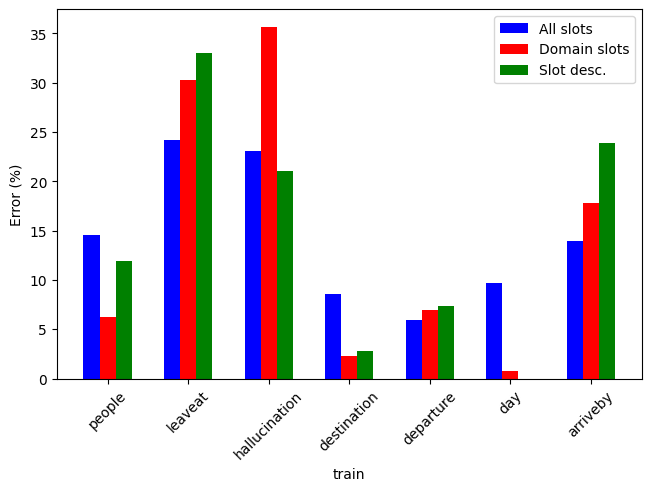

In [181]:
domain = "train"
data1 = error_comparison["all_slots"][domain]
data2 = error_comparison["domain_slots"][domain]
data3 = error_comparison["slot_description"][domain]

total_count1 = sum(data1.values())
total_count2 = sum(data2.values())
total_count3 = sum(data3.values())

percentages1 = {label: (count / total_count1) * 100 for label, count in data1.items()}
percentages1 = dict(sorted(percentages1.items(), key=lambda x:x[0], reverse=True))
percentages2 = {label: (count / total_count2) * 100 for label, count in data2.items()}
percentages2 = dict(sorted(percentages2.items(), key=lambda x:x[0], reverse=True))
percentages3 = {label: (count / total_count3) * 100 for label, count in data3.items()}
percentages3 = dict(sorted(percentages3.items(), key=lambda x:x[0], reverse=True))

labels = percentages1.keys()
counts1 = percentages1.values()
counts2 = percentages2.values()
counts3 = percentages3.values()

width = 0.2  # Width of each bar

fig, ax = plt.subplots(layout='constrained')
x = np.arange(len(labels))
plt.bar(x - width, list(counts1), width, label='All slots', color="blue")
plt.bar(x, list(counts2), width, label='Domain slots', color="red")
plt.bar(x + width, list(counts3), width, label='Slot desc.', color="green")
ax.set_xticks(x, labels)
ax.legend()

# plt.bar(labels, counts)
plt.xlabel(domain)
plt.ylabel('Error (%)')
# plt.title('Count per Label in Percentage')
plt.xticks(rotation=45)
plt.savefig(f"/home/willy/instructod/src/DST/figs/gpt3.5_{domain}_analysis.jpg")
plt.show()

In [99]:
percentages2

{'destination': 35.526315789473685,
 'departure': 22.36842105263158,
 'hallucination': 17.105263157894736,
 'leaveat': 17.105263157894736,
 'arriveby': 7.894736842105263}

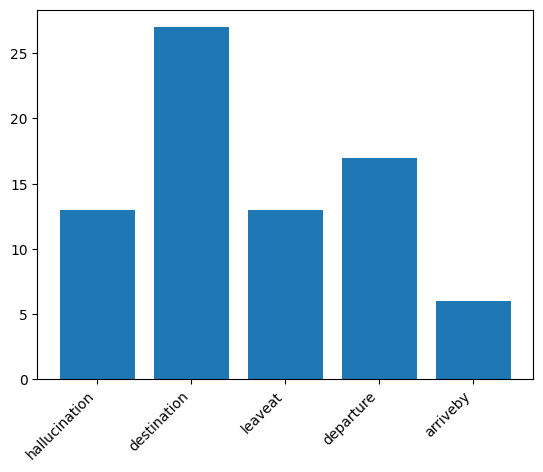

In [126]:
import matplotlib.pyplot as plt

domain = "taxi"

names = list(slot_error_distribution[domain].keys())
values = list(slot_error_distribution[domain].values())

plt.bar(range(len(slot_error_distribution[domain])), values, tick_label=names)
plt.xticks(rotation=45, ha="right")
plt.show()

In [44]:
domain_slots_fails = fail_ids.copy()

In [52]:
len(fail_ids)

65

In [45]:
len(domain_slots_fails)

76

In [53]:
diff = [id for id in domain_slots_fails if id not in fail_ids]

In [57]:
diff

[271,
 273,
 751,
 752,
 753,
 754,
 1270,
 1518,
 1520,
 3374,
 3375,
 3518,
 3922,
 5323,
 7099]

In [32]:
results_per_domain["train"]

{'total_bf_match': 95,
 'total_f1': 143.55808080808075,
 'total_samples': 160,
 'F1': 0.8972380050505047,
 'JGA': 0.59375}

In [38]:
results_per_domain["train"]

{'total_bf_match': 84,
 'total_f1': 143.56277056277045,
 'total_samples': 160,
 'F1': 0.8972673160173154,
 'JGA': 0.525}

In [70]:
id = 576
print(df.loc[df["id"] == id]["prompt_dst"].item())
print(df.loc[df["id"] == id]["preds"].item())
print(df.loc[df["id"] == id]["gold_bs"].item())

Generate the dialogue state of the following dialogue between a USER and a task-oriented dialogue SYSTEM. The results should be in a single python dictionary following this format: {"domain1-slot1":value1, "domain2-slot2":"value2"}. Use the provided domain and slots, and nothing else:

SLOTS:
name: hotel-day, description: day of the week for the booking or departure
name: hotel-people, description: number of people for booking
name: hotel-stay, description: stay duration in the place
name: hotel-area, description: cardinal location of the place of interest like north, center, west, etc...
name: hotel-internet, description: whether the place has internet or not
name: hotel-name, description: name of the place
name: hotel-parking, description: whether the place has parking or not
name: hotel-pricerange, description: price budget for the place
name: hotel-stars, description: star rating of the place
name: hotel-type, description: type of hotel building or attraction

You can follow this e

In [93]:
results_per_domain

{'taxi': {'total_bf_match': 112,
  'total_f1': 155.76904761904757,
  'total_samples': 185,
  'F1': 0.8419948519948517,
  'JGA': 0.6054054054054054},
 'attraction': {'total_bf_match': 20,
  'total_f1': 25.53333333333333,
  'total_samples': 40,
  'F1': 0.6383333333333333,
  'JGA': 0.5},
 'hotel': {'total_bf_match': 127,
  'total_f1': 298.8945994236246,
  'total_samples': 372,
  'F1': 0.8034801059774854,
  'JGA': 0.34139784946236557},
 'restaurant': {'total_bf_match': 154,
  'total_f1': 245.70357420357436,
  'total_samples': 285,
  'F1': 0.8621178042230679,
  'JGA': 0.5403508771929825},
 'train': {'total_bf_match': 87,
  'total_f1': 139.39734709734697,
  'total_samples': 160,
  'F1': 0.8712334193584186,
  'JGA': 0.54375},
 '': {'total_bf_match': 11,
  'total_f1': 14.944444444444445,
  'total_samples': 17},
 'JGA': 0.4825306893295562,
 'F1': 0.8312014599824082}

In [169]:
prompt = """Generate the dialogue state of the following dialogue between a USER and a task-oriented dialogue SYSTEM. The results should be in a single python dictionary following this format: {"domain1-slot1":value1, "domain2-slot2":"value2"}. Use the provided domain and slots, and nothing else:

SLOTS:
taxi-arriveBy
taxi-departure
taxi-destination
taxi-leaveAt

You can follow this example:
USER: I need a cheap hotel with internet in the west of town
BELIEF STATE: {"hotel-pricerange":"cheap,"hotel-internet":"yes", "hotel-area":"west"}

USER: I would like a taxi from Saint John's college to Pizza Hut Fen Ditton.
BELIEF STATE:"""

output = completion(prompt, "gpt-3.5-turbo")

In [170]:
print(output)

{"taxi-departure":"Saint John's college", "taxi-destination":"Pizza Hut Fen Ditton"}


In [221]:
idx = 10
print(df["prompt_dst"][idx])
print(df["preds"][idx])

Generate the dialogue state of the following dialogue between a USER and a task-oriented dialogue SYSTEM. The results should be in a single python dictionary following this format: {"domain1-slot1":value1, "domain2-slot2":"value2"}. Use the provided domain and slots, and nothing else:

SLOTS:
hotel-day
hotel-people
hotel-stay
hotel-area
hotel-internet
hotel-name
hotel-parking
hotel-pricerange
hotel-stars
hotel-type

You can follow this example:
USER: I need a cheap hotel with internet in the west of town
SYSTEM: Sure, anything else?
USER: Yes, I am looking with for italian food around the same area
BELIEF STATE: {"hotel-pricerange":"cheap,"hotel-internet":"yes", "hotel-area":"west", "restaurant-food":"italian", "restaurant-area":"west"}

CONTEXT:
USER: I would like it to have a 3 star rating. 


BELIEF STATES:
{"hotel-pricerange":"cheap,"hotel-internet":"yes", "hotel-area":"west", "hotel-stars":"3"}


In [ ]:
dh = 0
count = 0
count_fail = 0
running_bs = {}
prev_dialogue_id = ""
failed = False
bf_match = 0
correct_slots = 0
total_slots = 0
total_F1 = 0
L= len(df)
results_per_domain = {"taxi":{"total_bf_match":0,
                              "total_f1":0,
                              "total_samples":0},
                      "attraction":{"total_bf_match":0,
                                    "total_f1":0,
                                    "total_samples":0},
                      "hotel":{"total_bf_match":0,
                               "total_f1":0,
                               "total_samples":0},
                      "restaurant":{"total_bf_match":0,
                                    "total_f1":0,
                                    "total_samples":0},
                      "train":{"total_bf_match":0,
                               "total_f1":0,
                               "total_samples":0},
                      "":{"total_bf_match":0,
                          "total_f1":0,
                          "total_samples":0}}

for idx, row in df.iterrows():
    turn_domain = row["turn_domain"]
    cur_id = row["id"]
    cur_dialogue_id = row["dialogue_id"]
    dialogue_context = row["prompt_dst"].split("CONTEXT:\n")[-1][:-14]
    slots = [slot.lower() for slot in row["prompt_dst"].split("\n\n")[1].split("\n")[1:]]
    if prev_dialogue_id != cur_dialogue_id:
        running_bs = {}
    pred = row["preds"]
    raw_pred = pred
    # print(pred)

    try:
        pred = ast.literal_eval(pred)
        if isinstance(pred, tuple):
            preds = pred.copy()
            pred = preds[0]
            for d in preds[1:]:
                pred.update(d)    
        # if isinstance(pred, tuple):
        #     pred = preds[0].copy()
        #     for d in preds[1:]:
        #         pred.update(d)
    except:
        try:
            preds = [ast.literal_eval(pred.replace("null", "None")) for pred in pred.split("\n")]
            pred = preds[0].copy()
            for d in preds[1:]:
                pred.update(d)
        except:
            failed = True
            count_fail += 1
            pred = {}
    if dh == 0:
        running_bs.update(pred)
        fixed_pred = fix_pred(running_bs)
    elif dh == -1:
        fixed_pred = fix_pred(pred)
    set_pred = set([k + "-" + v for k, v in fixed_pred.items()])
    gold = ast.literal_eval(row["gold_bs"])
    fixed_gold = fix_gold(gold)
    set_gold = set([k + "-" + v for k, v in fixed_gold.items()])

    
    # slot-f1
    # turn_correct = 0
    turn_TP = 0
    turn_FN = 0
    turn_FP = 0
    # turn_total = 0
    for k, v in fixed_gold.items():
        if k in fixed_pred:
            if fixed_gold[k] == fixed_pred[k]:
                turn_TP += 1
            else:
                turn_FN += 1
        else:
            turn_FN += 1

    for k, v in fixed_pred.items():
        if k in fixed_gold:
            if fixed_gold[k] != fixed_pred[k]:
                turn_FP += 1
        else:
            turn_FP += 1

    # total_slots += turn_total
    # correct_slots += turn_correct
    turn_precision = turn_TP / float(turn_TP+turn_FP) if (turn_TP+turn_FP)!=0 else 0
    turn_recall = turn_TP / float(turn_TP+turn_FN) if (turn_TP+turn_FN)!=0 else 0
    turn_F1 = 2 * turn_precision * turn_recall / float(turn_precision + turn_recall) if (turn_precision+turn_recall)!=0 else 0

    total_F1 += turn_F1
    if turn_domain is np.nan:
        turn_domain = ""

    results_per_domain[turn_domain]["total_f1"] += turn_F1
    results_per_domain[turn_domain]["total_samples"] += 1
    
    
    if set_gold == set_pred:
        count += 1
        bf_match += 1
        results_per_domain[turn_domain]["total_bf_match"] += 1
    else:
        if turn_domain == "taxi":
            print("id", cur_id, " dialogue id", cur_dialogue_id)
            # print("dialogue_context", dialogue_context)
            print("domain", turn_domain)
            print("gold", fixed_gold)
            print("raw", raw_pred)
            print("pred", fixed_pred)
            print("----------")
        failed = False

    prev_dialogue_id = cur_dialogue_id
    
print(f"Total JGA: {(bf_match/L)*100:.2f}")
print(f"Total F1: {(total_F1/L)*100:.2f}")
print("----")

for domain in ["attraction", "hotel", "restaurant", "taxi", "train"]:
    print(f"Domain: {domain}")
    domain_f1 = results_per_domain[domain]['total_f1']/results_per_domain[domain]['total_samples']
    domain_jga = results_per_domain[domain]['total_bf_match']/results_per_domain[domain]['total_samples']
    print(f"JGA: {domain_jga*100:.2f}")
    print(f"F1: {domain_f1*100:.2f}")     
    results_per_domain[domain]["F1"] = domain_f1
    results_per_domain[domain]["JGA"] = domain_jga

results_per_domain["JGA"] = bf_match/L
results_per_domain["F1"] = total_F1/L